# Visualisasi Ekstraksi Fitur

Notebook ini mendemonstrasikan dan memvisualisasikan berbagai teknik ekstraksi fitur yang diterapkan pada satu gambar sampel. Tujuannya adalah untuk memahami bagaimana setiap fitur merepresentasikan informasi visual dari gambar.

In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from scipy.stats import skew

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from src.configs.config import DATA_RAW_PATH, CLASSES
from src.preprocessing.image_preprocessing import preprocess_image_for_feature_extraction
from src.features.feature_extraction import (
    extract_hog_features, extract_color_histogram, extract_lbp_features, 
    extract_gabor_features, extract_sobel_features, extract_glcm_features, 
    extract_color_moments, extract_features
)
from src.utils.dataset_loader import load_images_from_folder

## Gambar Sampel

Memuat dataset dan memilih satu gambar secara acak sebagai sampel. Gambar ini kemudian akan diproses (resize, normalisasi) untuk persiapan ekstraksi fitur.

2025-10-12 06:03:22,478 - INFO - dataset_loader - Memuat gambar dari 'd:\program\python-project\svm-models\build\data\raw'...
Loading Berkabut: 100%|██████████| 300/300 [00:01<00:00, 219.90it/s]
2025-10-12 06:03:27,890 - INFO - dataset_loader - Total gambar yang berhasil dimuat: 1200


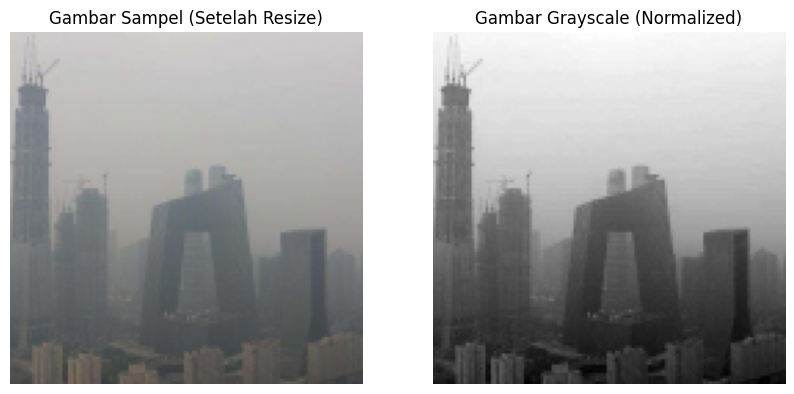

In [2]:
# Memuat semua gambar, label, dan nama file dari direktori data mentah
images, _, _ = load_images_from_folder(DATA_RAW_PATH)
# Memilih satu gambar secara acak dari dataset untuk dijadikan sampel
sample_image = random.choice(images)

# Melakukan prapemrosesan pada gambar sampel
normalized_gray, normalized_color, resized_uint8 = preprocess_image_for_feature_extraction(sample_image)

# Menampilkan gambar sampel asli (setelah di-resize) dan versi grayscale-nya
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cv2.cvtColor(resized_uint8, cv2.COLOR_BGR2RGB))
axes[0].set_title('Gambar Sampel (Setelah Resize)')
axes[0].axis('off')

axes[1].imshow(normalized_gray, cmap='gray')
axes[1].set_title('Gambar Grayscale (Normalized)')
axes[1].axis('off')

plt.show()

## Visualisasi Fitur HOG (Histogram of Oriented Gradients)

HOG menangkap informasi tentang gradien atau tepi pada gambar. Visualisasi HOG menunjukkan arah dominan gradien di setiap sel gambar.

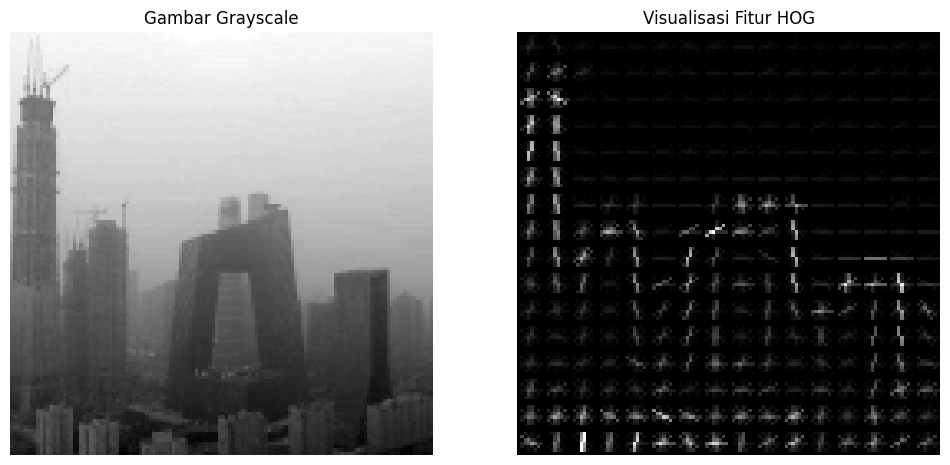

In [3]:
# Impor parameter HOG dari file konfigurasi
from src.configs.config import HOG_ORIENTATIONS, HOG_PIXELS_PER_CELL, HOG_CELLS_PER_BLOCK

# Ekstraksi fitur HOG dan gambar visualisasinya
hog_feats, hog_image = hog(
    normalized_gray,
    orientations=HOG_ORIENTATIONS,
    pixels_per_cell=HOG_PIXELS_PER_CELL,
    cells_per_block=HOG_CELLS_PER_BLOCK,
    block_norm='L2-Hys', # Metode normalisasi blok
    visualize=True,     # Menghasilkan gambar HOG
    transform_sqrt=True # Menerapkan koreksi gamma
)

# Menampilkan gambar grayscale asli bersama dengan visualisasi HOG-nya
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(normalized_gray, cmap='gray')
axes[0].set_title('Gambar Grayscale')
axes[0].axis('off')

axes[1].imshow(hog_image, cmap='gray')
axes[1].set_title('Visualisasi Fitur HOG')
axes[1].axis('off')

plt.show()

## Visualisasi Fitur Color Histogram

Histogram warna merepresentasikan distribusi intensitas warna dalam gambar (disini menggunakan ruang warna HSV). Ini berguna untuk mengidentifikasi objek berdasarkan warnanya, terlepas dari orientasinya.

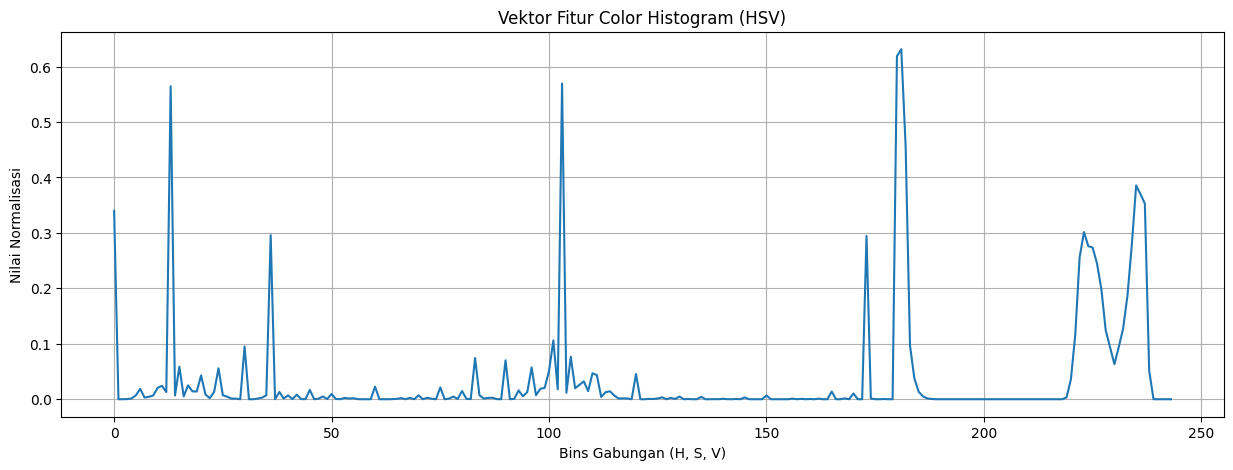

Ukuran vektor fitur Color Histogram: (244,)


In [4]:
# Ekstraksi fitur color histogram dari gambar berwarna yang sudah dinormalisasi
color_hist_feats = extract_color_histogram(normalized_color)

# Membuat plot untuk vektor fitur color histogram
plt.figure(figsize=(15, 5))
plt.plot(color_hist_feats)
plt.title('Vektor Fitur Color Histogram (HSV)')
plt.xlabel('Bins Gabungan (H, S, V)')
plt.ylabel('Nilai Normalisasi')
plt.grid(True)
plt.show()

# Menampilkan ukuran dari vektor fitur yang dihasilkan
print(f"Ukuran vektor fitur Color Histogram: {color_hist_feats.shape}")

## Visualisasi Fitur LBP (Local Binary Patterns)

LBP adalah deskriptor tekstur yang kuat. Fitur ini bekerja dengan membandingkan setiap piksel dengan piksel tetangganya. Gambar representasi LBP menyoroti pola tekstur lokal.

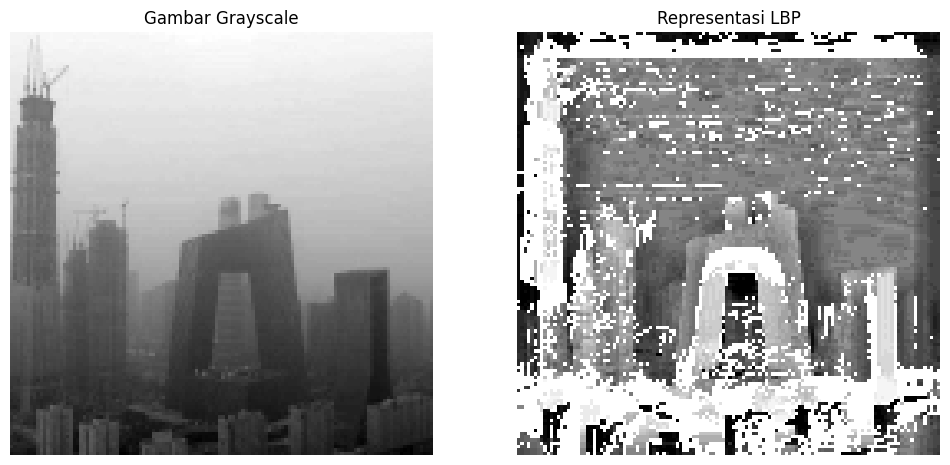

In [5]:
# Impor fungsi LBP
from skimage.feature import local_binary_pattern

# Tentukan parameter untuk LBP
radius = 8
n_points = 24

# Konversi gambar grayscale float ke uint8 untuk LBP
gray_image_uint8 = (normalized_gray * 255).astype(np.uint8)
# Hasilkan gambar representasi LBP
lbp_image = local_binary_pattern(gray_image_uint8, n_points, radius, method='uniform')
# Ekstrak vektor fitur LBP (histogram dari gambar LBP)
lbp_feats = extract_lbp_features(normalized_gray)

# Menampilkan gambar grayscale asli dan representasi LBP-nya
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(normalized_gray, cmap='gray')
axes[0].set_title('Gambar Grayscale')
axes[0].axis('off')

axes[1].imshow(lbp_image, cmap='gray')
axes[1].set_title('Representasi LBP')
axes[1].axis('off')

plt.show()

## Visualisasi Fitur GLCM (Gray-Level Co-occurrence Matrix)

GLCM adalah metode statistik untuk menganalisis tekstur yang mempertimbangkan hubungan spasial antar piksel. Matriks ini menunjukkan seberapa sering pasangan tingkat keabuan yang berbeda muncul bersamaan pada jarak dan sudut tertentu.

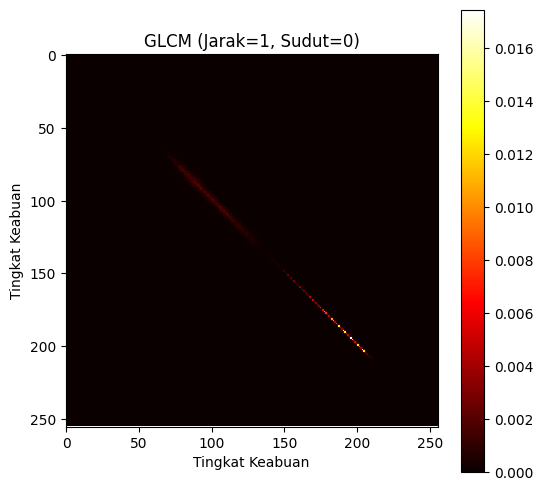

In [6]:
# Konversi gambar ke format uint8 yang diperlukan oleh GLCM
gray_image_uint8 = (normalized_gray * 255).astype(np.uint8)
# Hitung matriks GLCM
glcm = graycomatrix(gray_image_uint8, distances=[1], angles=[0], symmetric=True, normed=True)
# Ekstrak properti tekstur dari matriks GLCM (misalnya, kontras, energi)
glcm_feats = extract_glcm_features(normalized_gray)

# Visualisasikan matriks GLCM itu sendiri sebagai gambar heatmap
plt.figure(figsize=(6, 6))
# Tampilkan GLCM untuk jarak 1 dan sudut 0
plt.imshow(glcm[:, :, 0, 0], cmap='hot', interpolation='nearest')
plt.title('GLCM (Jarak=1, Sudut=0)')
plt.xlabel('Tingkat Keabuan')
plt.ylabel('Tingkat Keabuan')
plt.colorbar()
plt.show()

## Visualisasi Fitur Color Moments

Color moments (mean, standar deviasi, skewness) adalah ukuran statistik yang meringkas distribusi warna di setiap channel (di sini menggunakan ruang warna Lab). Fitur ini sangat ringkas namun efektif.

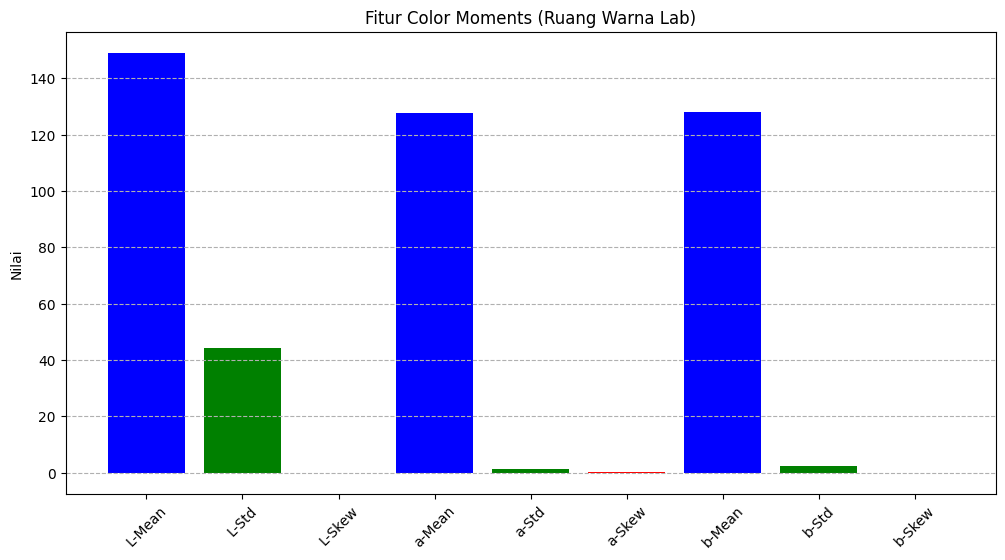

In [7]:
# Ekstrak fitur color moments
color_moments_feats = extract_color_moments(normalized_color)
# Siapkan label untuk sumbu-x pada plot
labels = ['L-Mean', 'L-Std', 'L-Skew', 'a-Mean', 'a-Std', 'a-Skew', 'b-Mean', 'b-Std', 'b-Skew']

# Buat bar chart untuk memvisualisasikan nilai-nilai fitur
plt.figure(figsize=(12, 6))
plt.bar(labels, color_moments_feats, color=['blue', 'green', 'red'] * 3)
plt.title('Fitur Color Moments (Ruang Warna Lab)')
plt.ylabel('Nilai')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

## Visualisasi Fitur Gabor Filters

Filter Gabor sangat baik dalam mendeteksi tekstur dan tepi pada orientasi dan frekuensi yang berbeda. Visualisasi di bawah ini menunjukkan bagaimana gambar merespons filter Gabor dengan orientasi yang berbeda-beda.

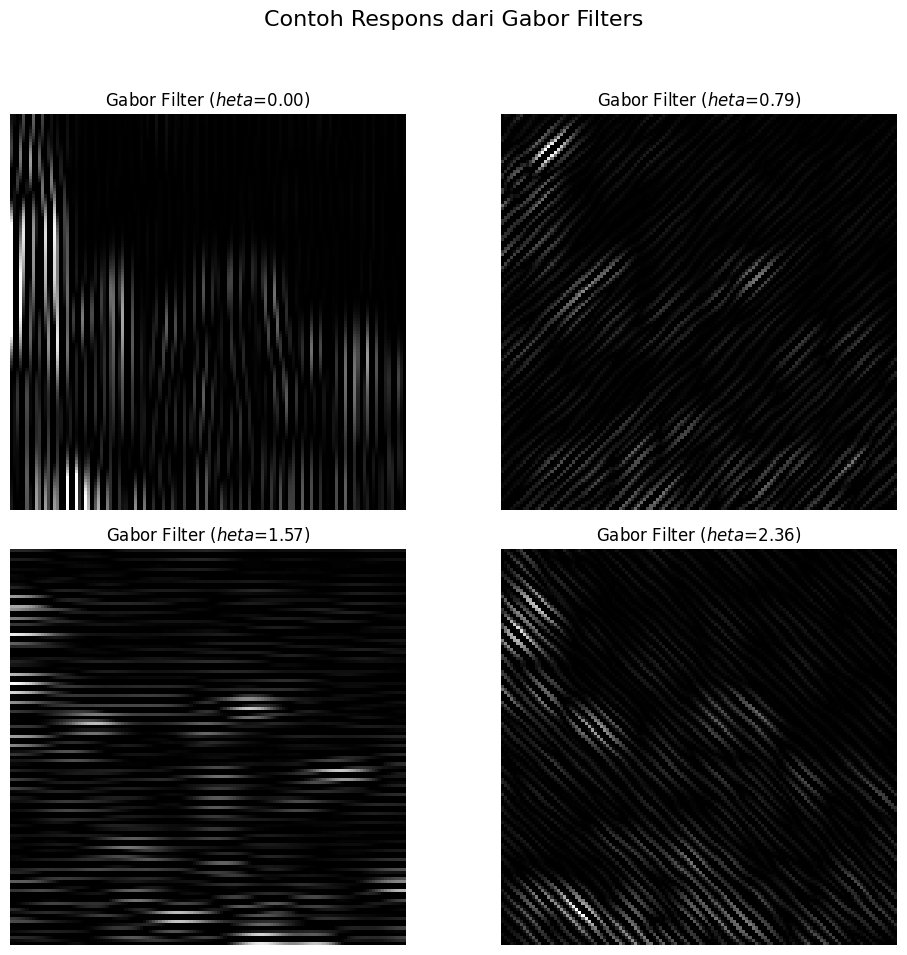

In [8]:
# Ekstrak fitur Gabor (mean dan standar deviasi dari respons filter)
gabor_feats = extract_gabor_features(normalized_gray)

# Persiapan untuk Visualisasi Respons Filter
ksize = 31 # Ukuran kernel Gabor
filters_for_viz = []
# Pilih beberapa orientasi untuk divisualisasikan
orientations_for_viz = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]

# Buat kernel Gabor untuk setiap orientasi yang dipilih
for theta in orientations_for_viz:
    kernel = cv2.getGaborKernel((ksize, ksize), sigma=3.0, theta=theta, lambd=np.pi, gamma=0.5, psi=0, ktype=cv2.CV_32F)
    filters_for_viz.append(kernel)

# Buat subplot untuk menampilkan hasil filter
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
img_for_viz = (normalized_gray * 255).astype(np.uint8)

# Terapkan setiap kernel ke gambar dan tampilkan hasilnya
for i, (ax, kernel) in enumerate(zip(axes.flatten(), filters_for_viz)):
    filtered_img = cv2.filter2D(img_for_viz, cv2.CV_8UC3, kernel)
    ax.imshow(filtered_img, cmap='gray')
    ax.set_title(f'Gabor Filter ($\theta$={orientations_for_viz[i]:.2f})')
    ax.axis('off')

plt.suptitle('Contoh Respons dari Gabor Filters', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Visualisasi Fitur Sobel Edge Detection

Operator Sobel adalah detektor tepi klasik yang menghitung gradien gambar. Ini menghasilkan gambar yang menyoroti tepi horizontal (Sobel Y), vertikal (Sobel X), dan magnitudo gradien secara keseluruhan.

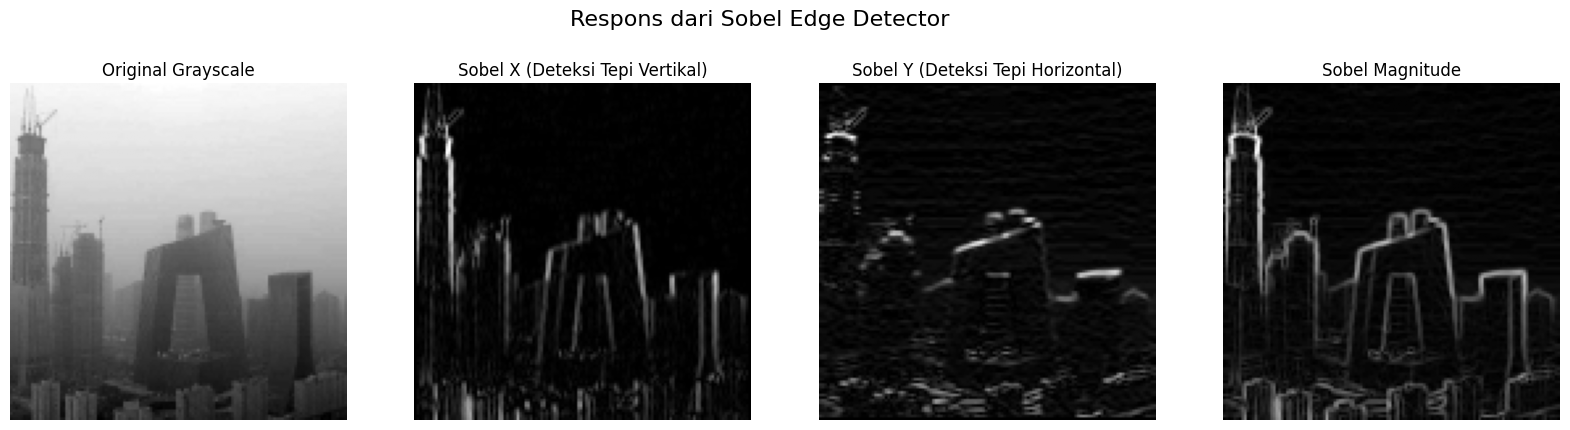

In [9]:
# Konversi gambar ke uint8 untuk operasi Sobel
img_uint8_sobel = (normalized_gray * 255).astype(np.uint8)
# Terapkan filter Sobel pada sumbu x (deteksi tepi vertikal)
sobelx = cv2.Sobel(img_uint8_sobel, cv2.CV_64F, 1, 0, ksize=3)
# Terapkan filter Sobel pada sumbu y (deteksi tepi horizontal)
sobely = cv2.Sobel(img_uint8_sobel, cv2.CV_64F, 0, 1, ksize=3)
# Hitung magnitudo gradien
magnitude = np.sqrt(sobelx**2 + sobely**2)

# Visualisasikan gambar asli, respons Sobel X, Y, dan magnitudo
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(normalized_gray, cmap='gray')
axes[0].set_title('Original Grayscale')
axes[0].axis('off')

axes[1].imshow(np.abs(sobelx), cmap='gray')
axes[1].set_title('Sobel X (Deteksi Tepi Vertikal)')
axes[1].axis('off')

axes[2].imshow(np.abs(sobely), cmap='gray')
axes[2].set_title('Sobel Y (Deteksi Tepi Horizontal)')
axes[2].axis('off')

axes[3].imshow(magnitude, cmap='gray')
axes[3].set_title('Sobel Magnitude')
axes[3].axis('off')

plt.suptitle('Respons dari Sobel Edge Detector', fontsize=16)
plt.show()

## Menggabungkan Semua Fitur

Terakhir, semua vektor fitur individual digabungkan menjadi satu vektor fitur tunggal yang akan digunakan untuk melatih model klasifikasi.

In [10]:
# Ekstrak kembali fitur Sobel untuk konsistensi (opsional, sudah diekstrak di atas)
sobel_feats = extract_sobel_features(normalized_gray)
# Gabungkan semua fitur menjadi satu vektor tunggal
combined_features = extract_features(normalized_gray, normalized_color)

# Tampilkan ukuran dari setiap vektor fitur individual
print(f"Ukuran HOG: {hog_feats.shape[0]}")
print(f"Ukuran Color Histogram: {color_hist_feats.shape[0]}")
print(f"Ukuran LBP: {lbp_feats.shape[0]}")
print(f"Ukuran GLCM: {glcm_feats.shape[0]}")
print(f"Ukuran Color Moments: {color_moments_feats.shape[0]}")
print(f"Ukuran Gabor: {gabor_feats.shape[0]}")
print(f"Ukuran Sobel: {sobel_feats.shape[0]}")
print("-----")
# Tampilkan ukuran total dari vektor fitur gabungan
print(f"Ukuran Vektor Fitur Gabungan: {combined_features.shape}")

Ukuran HOG: 8100
Ukuran Color Histogram: 244
Ukuran LBP: 26
Ukuran GLCM: 72
Ukuran Color Moments: 9
Ukuran Gabor: 48
Ukuran Sobel: 32
-----
Ukuran Vektor Fitur Gabungan: (8531,)
